In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy.io as sio
from PIL import Image
from eightpoint import eightpoint
from epipolarCorrespondence import epipolarCorrespondence
from essentialMatrix import essentialMatrix
from camera2 import camera2
from triangulate import triangulate
from displayEpipolarF import displayEpipolarF
from epipolarMatchGUI import epipolarMatchGUI

In [2]:
img1 = cv2.imread('../data/im1.png')
img2 = cv2.imread('../data/im2.png')
pts = np.load('../data/someCorresp.npy', allow_pickle=True).tolist()

In [3]:
pts1 = pts['pts1']      #(x,y) coordinate in piture 1
pts2 = pts['pts2']      #(x,y) coordinate in piture 2
M = pts['M']            #scalar parameter

# write your code here
R1, t1 = np.eye(3), np.zeros((3, 1))
R2, t2 = np.eye(3), np.zeros((3, 1))


In [4]:
F = eightpoint(pts1, pts2, M)

In [5]:
pts1.shape

(110, 2)

In [6]:
F = eightpoint(pts1, pts2, M)

In [7]:
print(F)

[[-1.33678811e-09  2.31692438e-08  5.53459462e-06]
 [ 6.29438961e-08 -1.61713023e-09 -5.11123511e-04]
 [-1.41707030e-05  4.92078162e-04  1.98672341e-03]]


In [8]:
M

1440.0

In [9]:
pts = np.load('../data/templeCoords.npy', allow_pickle=True).tolist()
pts1=pts['pts1']

In [10]:
pts2 = np.zeros_like(pts1)

# Iterate through each point in pts1 and find its corresponding point in im2
for i in range(pts1.shape[0]):
    pts2[i] = epipolarCorrespondence(img1, img2, F, np.array([pts1[i]]))

In [11]:
K = np.load('../data/intrinsics.npy', allow_pickle=True).tolist()
K1=K['K1']
K2 = K ['K2']
E = essentialMatrix(F, K1, K2)

In [12]:
P1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))

In [13]:
P2Candidates = camera2(E)

In [14]:
P2Candidates.shape

(3, 4, 4)

In [15]:
pts3d_candidate = triangulate(P1, pts1, P2Candidates[:, :, 1], pts2)

In [16]:
pts3d_candidate


array([[ 5.93614289e-03,  9.56058866e-03, -7.56399676e-02],
       [ 6.53057118e-03,  9.25951702e-03, -7.56103047e-02],
       [ 7.04180951e-03,  9.17857595e-03, -7.57602924e-02],
       [ 7.62810015e-03,  9.06542024e-03, -7.56447002e-02],
       [ 8.30560820e-03,  9.10405792e-03, -7.63850135e-02],
       [ 8.45068627e-03,  8.49722547e-03, -7.58834095e-02],
       [ 8.31816882e-03,  7.57657760e-03, -7.51374548e-02],
       [ 8.41575674e-03,  6.84599315e-03, -7.46880500e-02],
       [ 8.57229970e-03,  6.27832445e-03, -7.43417195e-02],
       [ 8.56601826e-03,  5.46363761e-03, -7.38663179e-02],
       [ 8.29064950e-03,  4.86370173e-03, -7.35783567e-02],
       [ 8.11889387e-03,  4.31915433e-03, -7.33384095e-02],
       [ 8.18480843e-03,  3.72849403e-03, -7.30657664e-02],
       [ 7.96966192e-03,  3.09710639e-03, -7.28563739e-02],
       [ 8.32605156e-03,  2.65878694e-03, -7.26213432e-02],
       [ 8.44217196e-03,  2.03354627e-03, -7.23884567e-02],
       [ 8.37523786e-03,  1.46090260e-03

In [17]:
min_distance = 1e12
min_distance1 = 1e12
min_distance2 = 1e12

for i in range(4):
    P2_candidate = P2Candidates[:, :, i]

    # Adjust P2 if the determinant is not 1
    if np.linalg.det(P2_candidate[:3, :3]) != 1:
        P2_candidate = K2 @ P2_candidate

    # Triangulate points
    pts3d_candidate = triangulate(P1, pts1, P2_candidate, pts2)

    # Project points back to image planes
    x1 = P1 @ np.hstack((pts3d_candidate, np.ones((pts3d_candidate.shape[0], 1)))).T
    x2 = P2_candidate @ np.hstack((pts3d_candidate, np.ones((pts3d_candidate.shape[0], 1)))).T

    # Normalize points
    epsilon = 1e-6  # A small threshold to prevent division by very small numbers
    x1[:, x1[2, :] > epsilon] /= x1[2, x1[2, :] > epsilon]
    x2[:, x2[2, :] > epsilon] /= x2[2, x2[2, :] > epsilon]

    # Check if all points are in front of the camera
    if np.all(pts3d_candidate[:, 2] > 0):
        distance1 = np.linalg.norm(pts1 - x1[:2, :].T) / pts3d_candidate.shape[0]
        distance2 = np.linalg.norm(pts2 - x2[:2, :].T) / pts3d_candidate.shape[0]
        distance = distance1 + distance2

        # Update if this is the minimum distance so far
        if distance < min_distance:
            min_distance = distance
            min_distance1 = distance1
            min_distance2 = distance2
            pts3d = pts3d_candidate
            P2 = P2_candidate

Min pts1 error: 0.13934052947982276
Min pts2 error: 0.14011750780081378


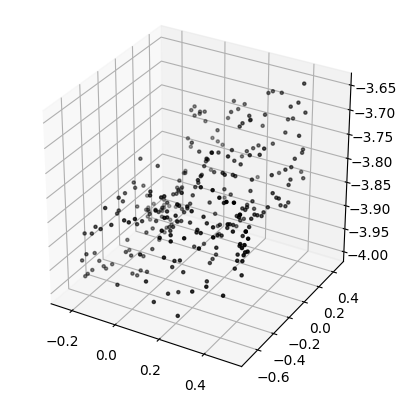

In [18]:
print(f'Min pts1 error: {min_distance1}')
print(f'Min pts2 error: {min_distance2}')

# Plot the 3D points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts3d_candidate[:, 0], pts3d_candidate[:, 1], pts3d_candidate[:, 2], c='k', marker='.')

# Set equal scaling
ax.set_box_aspect([1,1,1])  # matplotlib 3.1.0 and later

# Enable rotation
plt.show()

In [22]:
P = np.load('../results/extrinsics.npy', allow_pickle=True).tolist()
R1, R2 = P['R1'], P['R2']
t1, t2 = P['t1'], P['t2']

In [21]:
R1.shape

(3, 3)

In [23]:
t1.shape

(3,)